# Kaggle Challenge : Hire a Machine Learning Engineer

https://www.kaggle.com/datasets/sauravsolanki/hire-a-perfect-machine-learning-engineer

I realised this challenge during the "Parcours Recherche" of the Efrei Paris Engineering School. I worked under the tutelage of Eric Behar, PhD Candidate. This work was done in a month and the goal was to help my tutor to find an approach or a solution to problems of this kind.

## Importing the Data

In this part, I imported the librairies I worked with and my data.
The data in question is a job description and various CVs, all that in pdf format.
I use Natural Language Processing to lemmatize and removing all the stopwords in those files so i can work better with them.

In [1]:
import os
import spacy
from pdfminer.high_level import extract_text
import re
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

In [2]:
#I put here my values that I create at first
path =r'trainResumes/'
nlp = spacy.load("en_core_web_sm")
stopwords = nlp.Defaults.stop_words
empty_list = []

#I start with the lemmatization
job_description = nlp(extract_text('dataset/Job Description.pdf'))
for token in job_description:
    empty_list.append(token.lemma_)

job_description = ' '.join(map(str,empty_list))

#And after that I remove all the stopwords
lst=[]
for token in job_description.split():
    if token.lower() not in stopwords:
        lst.append(token)
job_description = ' '.join(lst)
job_description = job_description.lower()

In [3]:
#This cell puts all CV in a dictionnary with as the key the name of the CV, and as the value the content of it under a form of a string


#I put here my values that I create at first
list_of_files = []
list_of_pdf = []
list_of_dates = []
list_of_skills = ['data science', 'computer vision', 'natural language processing', 'ai', 'model', 'ml', 'master', 'machine learning', 'clustering', 'logistic regression', 'classification', 'scikit learn', 'numpy', 'pandas', 'matplotlib', 'seaborn', 'tensorflow', 'keras', 'pytorch', 'cnn', 'rnn', 'gan', 'nltk', 'spacy', 'beautifoul soup', 'pyspark', 'hadoop', 'nlp', 'ocr', 'opencv', 'django', 'mongodb', 'nosql', 'graphql', 'sql', 'firebase', 'aws', 'azure', 'google cloud'] 
chart = []
ml = 0

#I look here for all the files in a specific directory (here in the path I declared in the cell before)
for root, dirs, files in os.walk(path):
    for file in files:
        list_of_files.append(os.path.join(root,file))
    #I check that the file is well a pdf and if so I work with it
    for pdf in list_of_files:
        if pdf.count('.pdf'):
            cpt = 0
            empty_list = []
            pdf_working = nlp(extract_text(pdf))
   
            #I start with the lemmatization
            for token in pdf_working:
                empty_list.append(token.lemma_)
            pdf_working = ' '.join(map(str,empty_list))
   
            #And after that I remove all the stopwords
            lst=[]
            for token in pdf_working.split():
                if token.lower() not in stopwords:
                    lst.append(token)
            pdf_working = ' '.join(lst)

            #This part concerns the graph
            for i in list_of_skills:
                if i in pdf_working.lower():
                    cpt += 1
            if 'machine learning' in pdf_working.lower():
                ml += 1
            
            tmp = []
            match = re.match(r'.*([1-2][0-9]{3})', pdf_working)
            if match is not None:
                tmp.append(int(match.group(1)))
                tmp.sort()
                list_of_dates.append(tmp[0])     
                
            #I put everything I need in my list, the firstly the name of the pdf then the content
            list_of_pdf.append(pdf.rsplit('/')[-1][:-4])
            list_of_pdf.append(pdf_working.lower())
            chart.append(cpt)

#And I end by transforming the list to a dict : [1,2,3,4] becomes {1 : 2, 3 : 4}
dict_of_pdf = {list_of_pdf[i]: list_of_pdf[i + 1] for i in range(0, len(list_of_pdf), 2)}

## Data Analysis

My goal here was to have a better understanding of the dataset I worked with.
To do so, I did 4 different data analysis.

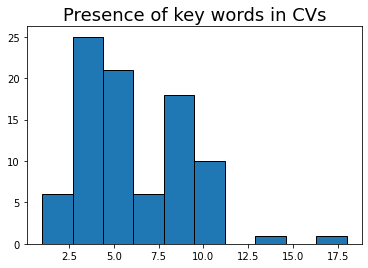

In [4]:
#Computation and creation of a histogram

fig0, ax0 = plt.subplots()

plt.hist(chart, edgecolor='black')
ax0.set_title("""Presence of key words in CVs""", fontsize=18)
plt.show()

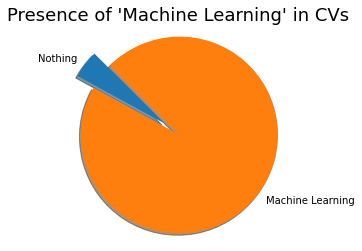

In [5]:
pie = [int(len(list_of_pdf)/2) - ml, ml]
labels = ['Nothing', 'Machine Learning']


#Computation and creation of a pie chart

fig1, ax1 = plt.subplots()
explode = (0, 0.2) 
ax1.pie(pie, explode=explode, labels=labels, shadow=True, startangle=135)
ax1.axis('equal')
ax1.set_title("""Presence of 'Machine Learning' in CVs""", fontsize=18)
plt.show()

In [6]:
diploma_date = 2022 - sum(list_of_dates)/len(list_of_dates)
print("The average diploma is {:.1f} old.".format(diploma_date))

The average diploma is 2.5 old.


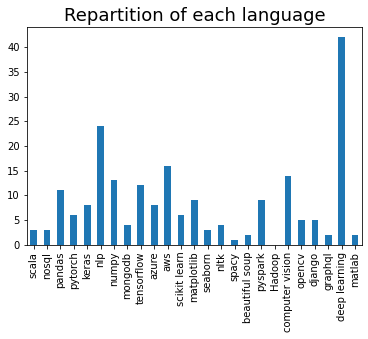

In [7]:
final_dict = {'candidate':list(map(lambda x:x.split("_")[1] ,list(dict_of_pdf.keys()))),'text_cv':list(dict_of_pdf.values())}
df = pd.DataFrame(final_dict)

list_of_tech = ['scala', 'nosql', 'pandas', 'pytorch', 'keras', 'nlp', 'numpy', 'mongodb', 'tensorflow', 'azure', 'aws', 'scikit learn', 'matplotlib', 'seaborn', 'nltk', 'spacy', 'beautiful soup', 'pyspark', 'Hadoop', 'computer vision', 'opencv', 'django', 'graphql', 'deep learning', 'matlab']
for tech in list_of_tech: 
    df[tech] = df.text_cv.apply(lambda x: 1 if tech in x else 0)
df['SumTechno(s)'] = df[list_of_tech].sum(axis=1)

fig2, ax2 = plt.subplots()

df[list_of_tech].sum().plot.bar()

ax2.set_title("""Repartition of each language""", fontsize=18)
plt.show()

## Score Computation

In the end, I reaslised that trying to rank all the CVs could be as interesting as trying to find a match percentage.

In [8]:
df["distanceFromMean"] = df['SumTechno(s)'].apply(lambda x: x - df['SumTechno(s)'].mean())

In [9]:
#We apply a bonus/malus to the Cvs that has a lot of techs, but the bonus is bounded between the 0.1 and 0.9 quantile.
df["bonusNumTech"] = df["distanceFromMean"].apply(lambda x: max(df["distanceFromMean"].quantile(q=0.1),min(x,df["distanceFromMean"].quantile(q=0.9))))

In [10]:
def get_techs_job_description(job_description, list_of_tech):
    list_job = job_description.split(" ")
    return np.array([ 1 if tech in list_job else 0 for tech in list_of_tech])

techs_job = get_techs_job_description(job_description, list_of_tech)

In [11]:
# Get the percentage of matching techs
def get_matching_techs(row,job_description):
    return (row[list_of_tech].to_numpy() * get_techs_job_description(job_description, list_of_tech)).sum()/get_techs_job_description(job_description, list_of_tech).sum()
#get_matching_techs(df.iloc[0,:],job_description)

In [25]:
#TODOThe experience bonus

In [13]:
#Scoring and Matching
def score(row,job_description):
    return (row["distanceFromMean"] + get_matching_techs(row,job_description)*10)

In [14]:
df["Score"] = df.apply(lambda x: score(x,job_description), axis = 1)

## Score Comparaison

Here is the final part, the comparaison of the score I found with the score given in the Kaggle challenge.

In [21]:
df_theory = pd.read_csv('dataset/train.csv')
df_theory["candidate"] = df_theory['CandidateID'].apply(lambda x:x.split("_")[1])
df_theory.drop('CandidateID', axis=1, inplace=True)
df = pd.merge(df, df_theory, on = "candidate", how = "inner")

In [22]:
df_final = df.sort_values(by='Score', ascending = False)

In [23]:
df_final.head(3)

,candidate,text_cv,scala,nosql,pandas,pytorch,keras,nlp,numpy,mongodb,...,django,graphql,deep learning,matlab,SumTechno(s),distanceFromMean,bonusNumTech,Score,Match Percentage_x,Match Percentage_y
15,063,joseline hernandez d t s c e n t s t n d m c h...,0,0,1,1,1,1,1,0,...,0,0,1,0,9,6.590909,3.590909,11.035354,53.66,53.66
56,143,m t t h e w h o r r e s j u n o r d e v e l o ...,0,0,0,1,0,1,1,0,...,0,0,1,0,8,5.590909,3.590909,8.368687,13.73,13.73
43,025,wyatt cooper d t s t r t e g y n d d e l v e r...,0,0,0,1,1,1,0,0,...,0,0,1,0,7,4.590909,3.590909,7.924242,43.17,43.17


In [24]:
df_final.tail(3)

,candidate,text_cv,scala,nosql,pandas,pytorch,keras,nlp,numpy,mongodb,...,django,graphql,deep learning,matlab,SumTechno(s),distanceFromMean,bonusNumTech,Score,Match Percentage_x,Match Percentage_y
33,015,john allen b u s n e s s n l y s t executive p...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,-2.409091,-2.409091,-2.409091,8.01,8.01
14,116,e v e r e t t b u r n s l e y data analyst avi...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,-2.409091,-2.409091,-2.409091,50.86,50.86
60,079,j u l c h e n j u n o r e n g n e e r executiv...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,-2.409091,-2.409091,-2.409091,39.55,39.55


# End